In [13]:
from src_2020.Parser import parse

def examine(filename):
    nb_books, nb_lib, nb_days, scores, libs,books = parse(filename)
    print(filename)
    print(nb_books,"books")
    print(nb_lib,"libraries")
    print(nb_days,"days")
    print("scores",scores[:10],"..")
    print(libs[0].interest1(1))
    print("--\n")
    
examine("a_example.txt")
examine("b_read_on.txt")
examine("c_incunabula.txt")
examine("d_tough_choices.txt")
examine("e_so_many_books.txt")
examine("f_libraries_of_the_world.txt")


a_example.txt
6 books
2 libraries
7 days
scores [1, 2, 3, 6, 5, 4] ..
90.0
--

b_read_on.txt
100000 books
100 libraries
1000 days
scores [100, 100, 100, 100, 100, 100, 100, 100, 100, 100] ..
9810000000.0
--

c_incunabula.txt
100000 books
10000 libraries
100000 days
scores [524, 235, 342, 133, 537, 438, 97, 198, 104, 100] ..
0
--

d_tough_choices.txt
78600 books
30000 libraries
30001 days
scores [65, 65, 65, 65, 65, 65, 65, 65, 65, 65] ..
26312000.0
--

e_so_many_books.txt
100000 books
1000 libraries
200 days
scores [51, 127, 187, 161, 26, 140, 160, 180, 207, 164] ..
0
--

f_libraries_of_the_world.txt
100000 books
1000 libraries
700 days
scores [277, 467, 206, 176, 115, 41, 251, 677, 367, 307] ..
0
--



In [14]:
%matplotlib inline
import seaborn as sns
import pandas as pd

#nb_books, nb_libs, nb_days, scores, libs, books = parse("e_so_many_books.txt")
#nb_books, nb_libs, nb_days, scores, libs, books = parse("c_incunabula.txt")
#nb_books, nb_libs, nb_days, scores, libs, books = parse("f_libraries_of_the_world.txt")
#nb_books, nb_libs, nb_days, scores, libs, books = parse("b_read_on.txt")
nb_books, nb_libs, nb_days, scores, libs, books = parse("d_tough_choices.txt")



def analyze(libs):
    global scores
    libs_books_values = []
    libs_nb_books = []
    mean_lib_books_scores = []
    sum_lib_books_scores = []
    for lib in libs:
        libs_books_values += [[scores[book.ide] for book in lib.books]]
        total_score = sum([scores[book.ide] for book in lib.books]) 
        mean_score = (total_score / len(lib.books)) if len(lib.books) > 0 else 0
        mean_lib_books_scores += [mean_score]
        libs_nb_books += [len(lib.books)]
        sum_lib_books_scores += [total_score]
        for book in lib.books:
            score = scores[book.ide]
            if score < 0:
                print("negative score?",score)

    dc = dict([(i,pd.Series(libs_books_values[i])) for i in range(len(libs_books_values))])
    #print(dc)
    df = pd.DataFrame(data=dc)
    #print(df)
    import matplotlib.pyplot as plt
    plt.figure(figsize=(45,10))
    #sns.boxplot(data=df).set_title('boxplot of books scores per library') # slow, maybe disable it
    return libs_books_values, libs_nb_books, mean_lib_books_scores, sum_lib_books_scores

libs_books_values, libs_nb_books, mean_lib_books_scores, sum_lib_books_scores = analyze(libs)

<Figure size 3240x720 with 0 Axes>

/home/rayan/.local/lib/python3.6/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'histogram of mean book score per library')

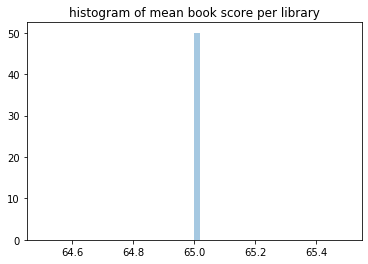

In [15]:
sns.distplot(mean_lib_books_scores).set_title('histogram of mean book score per library')

Text(0.5, 1.0, 'histogram of number of books per  library')

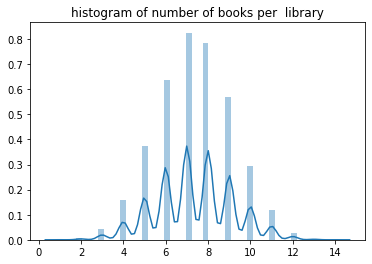

In [16]:
sns.distplot(libs_nb_books).set_title('histogram of number of books per  library')

Text(0.5, 1.0, 'histogram of total scores (summed for all books) per library')

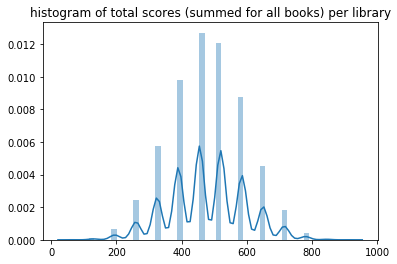

In [17]:
sns.distplot(sum_lib_books_scores).set_title('histogram of total scores (summed for all books) per library')

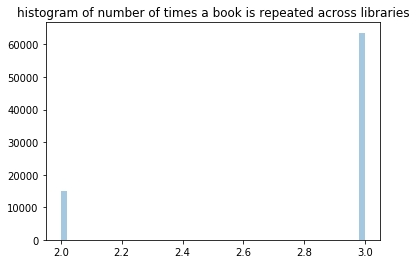

In [33]:
from collections import Counter
booksc = Counter()
for lib in libs:
    for book in lib.books:
        booksc[book.ide] += 1
sns.distplot(list(booksc.values()), hist=True, kde=False).set_title('histogram of number of times a book is repeated across libraries')
"""
for book in booksc:
    if booksc[book] > 20:
        print(book,booksc[book])
"""
None


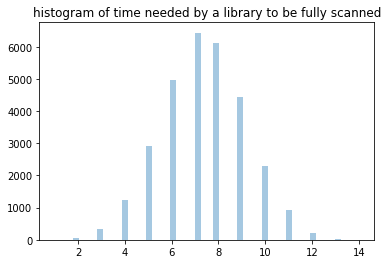

In [34]:
import math
def plot_time_needed(libs,label=""):
    list_time_needed = []
    for lib in libs:
        time_needed = math.ceil(len(lib.books) / lib.ship)
        list_time_needed += [time_needed]
    return sns.distplot(list_time_needed,label=label,hist=True, kde=False).set_title('histogram of time needed by a library to be fully scanned')
plot_time_needed(libs)
None

average frequency of a book 2.8091603053435112


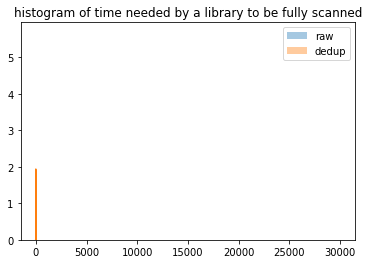

In [20]:
import matplotlib.pyplot as plt
def deduplicate_books(libs,duplication_threshold=1):
    import heapq
    from copy import deepcopy
    from collections import Counter
    booksc = Counter()
    dedup_libs = deepcopy(libs)
    for lib in libs:
        for book in lib.books:
            booksc[book.ide] += 1
    print("average frequency of a book",sum([booksc[b] for b in books]) / len(books))
    libq = []
    # use a pq to control how imbalance when removing books from libraries, 
    # possible strategies:
    # - making them as evenly containing books as possible
    # - force some libs to have as many books as poss (and schedule them at the beginning)
    #selection_function = lambda lib_i: len(dedup_libs[lib_i].books)
    #selection_function = lambda lib_i: len(dedup_libs[lib_i].books)/(lib_i+1)
    selection_function = lambda lib_i: -sum([book.score for book in dedup_libs[lib_i].books])
    #selection_function = lambda lib_i:  -(len(dedup_libs[lib_i].books) / dedup_libs[lib_i].ship) # time needed
    #selection_function = lambda lib_i:  dedup_libs[lib_i].urgency
    for lib_i,lib in enumerate(dedup_libs):
        heapq.heappush(libq, (selection_function(lib_i), lib_i))
    while len(booksc) > 0:
        _, lib_i = heapq.heappop(libq)
        deleted_a_book = False
        for book in dedup_libs[lib_i].books:
            if book.ide in booksc:
                if booksc[book.ide] > duplication_threshold:
                    dedup_libs[lib_i].books.remove(book)
                    booksc[book.ide] -= 1
                if booksc[book.ide] <= duplication_threshold:
                    del booksc[book.ide]
                deleted_a_book = True
                break
        if deleted_a_book: # if not: nothing to do anymore for this lib
            heapq.heappush(libq, (selection_function(lib_i), lib_i))
    return dedup_libs

plot_time_needed(libs,label="raw")
plot_time_needed(deduplicate_books(libs),label="dedup")
plt.legend()
plt.plot([nb_days,nb_days], [0,0.0015],color='red') # draw line at nb days
None

In [21]:
libs_books_values, libs_nb_books, mean_lib_books_scores, sum_lib_books_scores = analyze(deduplicate_books(libs,duplication_threshold=1))

average frequency of a book 2.8091603053435112


<Figure size 3240x720 with 0 Axes>

average frequency of a book 2.8091603053435112


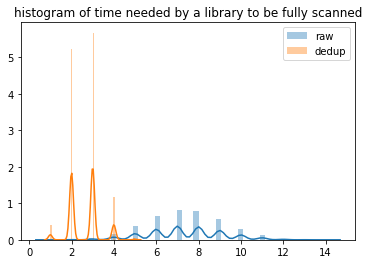

In [22]:
#unfinished WIP

import matplotlib.pyplot as plt
def smooth_books(libs,duplication_threshold=1):
    booksc = Counter()
    smooth_libs = deepcopy(libs)
    for lib in libs:
        for book in lib.books:
            booksc[book.ide] += 1
    print("average frequency of a book",sum([booksc[b] for b in books]) / len(books))
    categories = dict()
    for lib in smooth_libs:
        #lib.time_needed = len(lib.books) / lib.ship
        #categories[lib.time_needed] = lib.ide
        pass
    print(categories)
    return smooth_libs


plot_time_needed(libs,label="raw")
plot_time_needed(deduplicate_books(libs),label="dedup")
plt.legend()
None

Text(0.5, 1.0, 'histogram of books intersection cardinality between two libraries')

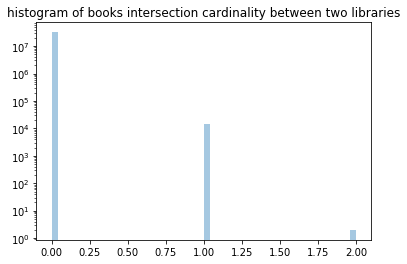

In [43]:
import random
intersections = []
libs_sample = random.sample(libs, 8000) # because for instance d there are too many libs
for lib1 in libs_sample:
    for lib2 in libs_sample:
        if lib1.ide >= lib2.ide: continue
        intersections += [len(set(lib1.books) & set(lib2.books))]
sns.distplot(intersections,hist=True, kde=False, hist_kws={'log':True}).set_title('histogram of books intersection cardinality between two libraries')

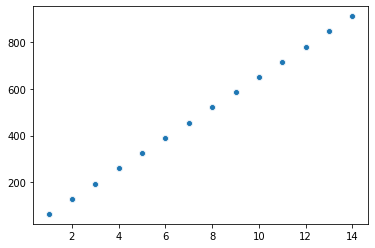

In [45]:
libsizes = []
libworths = []
for lib in libs:
    libsizes += [lib.libsize]
    libworths += [lib.libworth]
sns.scatterplot(libsizes,libworths)
    